
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mettinger/activeInference/blob/main/hiddenMarkov.ipynb)

*Note*: When running this notebook in Google Colab, you probably have to run `!pip install pyro-ppl`. The cell below is commented out in case you are running this notebook locally with Pyro already installed.  For use on Colab uncomment the cell and run the cell.  After Colab installs Pyro, you may need to restart the Colab runtime.

In [ ]:
# ! pip3 install pyro-ppl 

In [20]:
import math
import os
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
import numpy as np

from IPython.display import Image

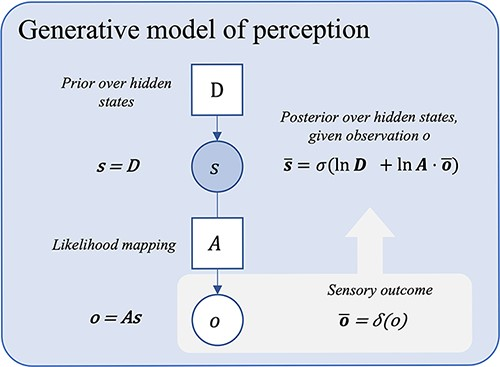

In [21]:
Image(filename='./images/basicPerception.jpeg') 

### Specify the true data generation process

In [18]:
numStates = 6
numOutcomes = 6
numObservations = 10
trueDistribution = np.array([.5,.5,0,0,0,0])

seed = 17
np.random.seed(seed) # for reproducibility

likelihoodMatrix = np.eye(6)
observationDistribution = np.dot(likelihoodMatrix, trueDistribution)

observations = np.random.choice(numOutcomes, size=numObservations, replace=True, p=observationDistribution)
print("Observations: ")
print(observations)

Observations: 
[0 1 0 0 1 1 1 1 0 0]


### Define various models and guides.  "Guide" is the Pyro terminology for the variational distribution which approximates the true posterior

In [19]:
# clear the param store in case we're in a REPL
pyro.clear_param_store()

def modelAccurate(data):
    # loop over the observed data
    for i in range(len(data)):
        pyro.sample("obs_{}".format(i), dist.Categorical(trueDistribution), obs=data[i])

def guideAccurate(data):
    # register the two variational parameters with Pyro
    # - both parameters will have initial value 15.0.
    # - because we invoke constraints.positive, the optimizer
    # will take gradients on the unconstrained parameters
    # (which are related to the constrained parameters by a log)
    alpha_q = pyro.param("alpha_q", torch.tensor(15.0),
                         constraint=constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor(15.0),
                        constraint=constraints.positive)
    # sample latent_fairness from the distribution Beta(alpha_q, beta_q)
    pyro.sample("latent_fairness", dist.Beta(alpha_q, beta_q))

In [ ]:
model = modelAccurate
guide = guideAccurate

# setup the optimizer
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

n_steps = 1000
# do gradient steps
for step in range(n_steps):
    svi.step(data)
    if step % 100 == 0:
        print(str(step) + '\n', end='')

# grab the learned variational parameters
alpha_q = pyro.param("alpha_q").item()
beta_q = pyro.param("beta_q").item()

# here we use some facts about the Beta distribution
# compute the inferred mean of the coin's fairness
inferred_mean = alpha_q / (alpha_q + beta_q)
# compute inferred standard deviation
factor = beta_q / (alpha_q * (1.0 + alpha_q + beta_q))
inferred_std = inferred_mean * math.sqrt(factor)

print("\nBased on the data and our prior belief, the fairness " +
      "of the coin is %.3f +- %.3f" % (inferred_mean, inferred_std))